<a href="https://colab.research.google.com/github/ClownEmojiIsHumor/Car_Crash_Investigation/blob/main/vehicleEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
vehicle_codes = {
    '01': 'Passenger cars',
    '02': 'Passenger van - multi-purpose vehicles with van bodies designed primarily for passenger transport',
    '03': 'Light utility vehicles - vehicles on truck chassis designed for passenger transport and for off-road use (e.g. Blazer, Bronco)',
    '04': 'Pickup trucks under 4536 kg. - pickups with open load bed, with camper top, etc.',
    '05': 'Panel cargo/vans under 4536 kg. - panel or window type van designed primarily for carrying goods',
    '06': 'Other trucks and vans under 4536 kg. - unspecified, or any other types of LTVs that do not fit into the above categories (e.g. delivery or service vehicles, small tow trucks, etc.)',
    '07': 'Unit trucks over 4536 kg - all heavy unit trucks, with or without a trailer (e.g. water trucks)',
    '08': 'Road tractor - with or without a semi-trailer',
    '09': 'School bus',
    '11': 'Urban transit bus',
    '12': 'Inter-city bus',
    '14': 'Motorcycle - motorized two or three wheeled vehicles capable of speeds greater than 70 km/h',
    '15': 'Limited speed motorcycle - motorized two or three wheeled vehicles with top speed less than 70 km/h (e.g. small scooters, mopeds)',
    '16': 'Off road vehicles – e.g. ATVs',
    '17': 'Bicycle - any number of wheels',
    '18': 'Purpose-built motorhome - excludes pickup campers',
    '19': 'Farm equipment',
    '20': 'Construction equipment',
    '22': 'Snowmobile',
    'QQ': 'Choice is other than preceding values',
    'UU': 'Unknown'
}
vehicle_manoeuvres = {
    "01": "Going straight ahead",
    "02": "Turning left",
    "03": "Turning right",
    "04": "Making U-turn",
    "05": "Changing lanes",
    "06": "Merging into traffic",
    "07": "Reversing",
    "08": "Overtaking, passing",
    "09": "Negotiating a curve",
    "10": "Slowing or stopped in traffic",
    "11": "Starting in traffic",
    "12": "Leaving roadside",
    "13": "Stopped/parked legally – excludes vehicles stopped in traffic",
    "14": "Stopped/parked illegally – excludes vehicles stopped in traffic",
    "15": "Swerving to avoid collision",
    "16": "Run-away or roll-away vehicle",
    "21": "Vehicle manoeuvre unspecified",
    "QQ": "Choice is other than the preceding values – e.g. vehicle being pushed or walked",
    "UU": "Unknown – e.g. hit-and-run cars"
}


In [4]:
dataPath = '/content/drive/MyDrive/data 601/combined.xlsx'
collisonDf = pd.read_excel(dataPath)

1. **What type of vehicles are most likely to be in a collision**

In [5]:

# map to col name : string
# V_REP' : 'Vehicle Replicate'
vehicleFields = {'V_TYPE':'Vehicle Type', 'V_LITE':'Use of Vehicle Headlights', 'V_MNVR': 'Vehicle Manoeuvre',
                'V_YEAR':'Vehicle Model Year', 'V_LICJ':'Vehicle Licence Plate Jurisdiction', 'V_REP' : 'Vehicle Replicate'}

excludeFields = set() # for placeholder functionality incase we would like to exclude some variable.

vehicleDf =  collisonDf[vehicleFields.keys()]
print(vehicleDf.columns)


Index(['V_TYPE', 'V_LITE', 'V_MNVR', 'V_YEAR', 'V_LICJ', 'V_REP'], dtype='object')


In [6]:
print(vehicleDf['V_REP'].value_counts())
print(vehicleDf.shape)

V_REP
x    25366
Name: count, dtype: int64
(35074, 6)


In [7]:
# We have some duplicate entries - we will remove them
# if V_REP == 'x' it implies that it is the first record.
vehicleDf = vehicleDf[vehicleDf['V_REP'] == 'x']
print(vehicleDf.columns)

Index(['V_TYPE', 'V_LITE', 'V_MNVR', 'V_YEAR', 'V_LICJ', 'V_REP'], dtype='object')


In [8]:
#TODO - Add different methods - classification model potentially to perform imputations
""" Function that deals with 'unknown' values for a given column
It supports the following methods
'R': Remove the observations
'M': Replace with the mode of the column
'V': Replace with the value in the 'val' argument
"""
def cleanUnknown(_df, colName, method, unknownVal, val=None):
  # print(colName, _df.columns)
  if method == 'R':
      # delete unkowns
      _df =  _df[_df[colName] != unknownVal]
  elif method == 'M':
      # replace the unknowns with mode
      modeVal = _df[colName].mode()[0]
      _df[colName]  =  _df[colName].replace(unknownVal, modeVal)
  elif method == 'V':
      # replace the unkowns with val
      _df[colName]  =  _df[colName].replace(unknownVal, val)

  return _df


""" Function deals with unkowns based off given mapping for an entire dataframe.
if a column maps to None, no cleaning is performed. This cleaning is done by
calling the cleanUnkown function.
"""
def cleanUnknowns(_df, colMethodMap, colUnknownMap, colValMap=None):
  for col, method in colMethodMap.items():
    if method is not None:
      colVal = None if colValMap is None else colValMap[col]
      _df = cleanUnknown(_df, col, method, colUnknownMap[col], colVal)
  return _df


In [9]:
""" Function that creates a variation of different dfs, with different cleaning methods.
So you can ideally investigate with all different methods.
It invokes the cleanUnkowns function to do so.
ATM just planning on implementing striaght up all Ms or all Rs as the option
After cleaning these dfs it returns outputlist which has these cleanings appended to as a tuple.
The first element of the tuple indicates the type of method of unknown replacement performed.
"""
def createCleanedDfs(_df, colUnknownMap, outputList = []):
  colsToClean = colUnknownMap.keys()
  dfRemove = _df.copy()
  dfMode = _df.copy()

  colMethodMapR = {col: 'R' for col in colsToClean}
  colMethodMapM = {col: 'M' for col in colsToClean}

  # Clean the dfs using the different methods
  dfRemoveCleaned = cleanUnknowns(dfRemove, colMethodMapR, colUnknownMap)
  dfModeCleaned = cleanUnknowns(dfMode, colMethodMapM, colUnknownMap)

  # Append the cleaned df to the output list as tuples
  outputList.append(('Remove', dfRemoveCleaned))
  outputList.append(('Mode', dfModeCleaned))
  outputList.append(('None', _df.copy()))

  return outputList

# Create Cleaned dfs
unknownMap = {'V_TYPE':'UU', 'V_LITE':'U', 'V_MNVR': 'UU', 'V_YEAR':'UUUU', 'V_LICJ':'UU'}
cleanedDfs = createCleanedDfs(vehicleDf, unknownMap)

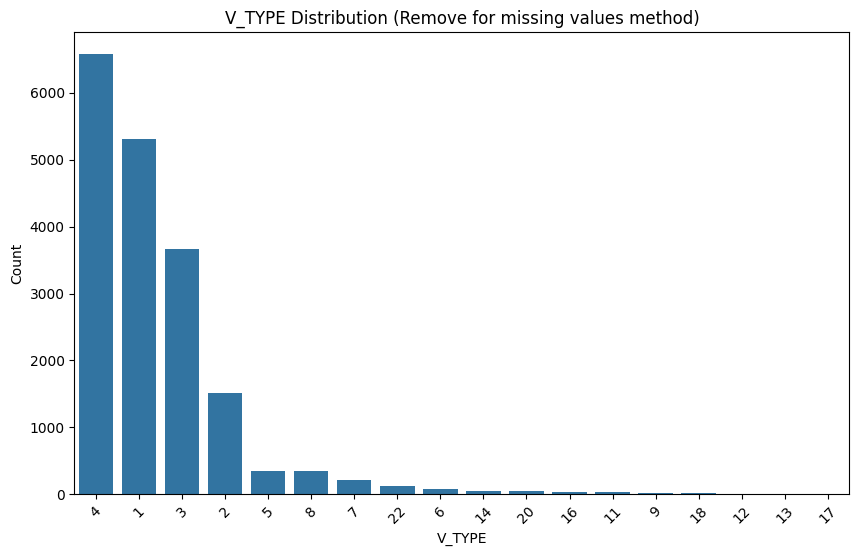

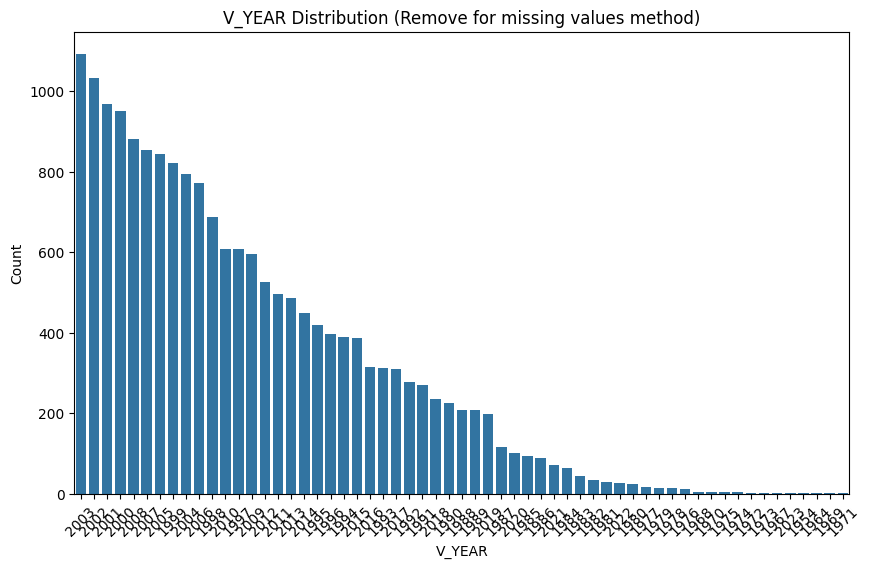

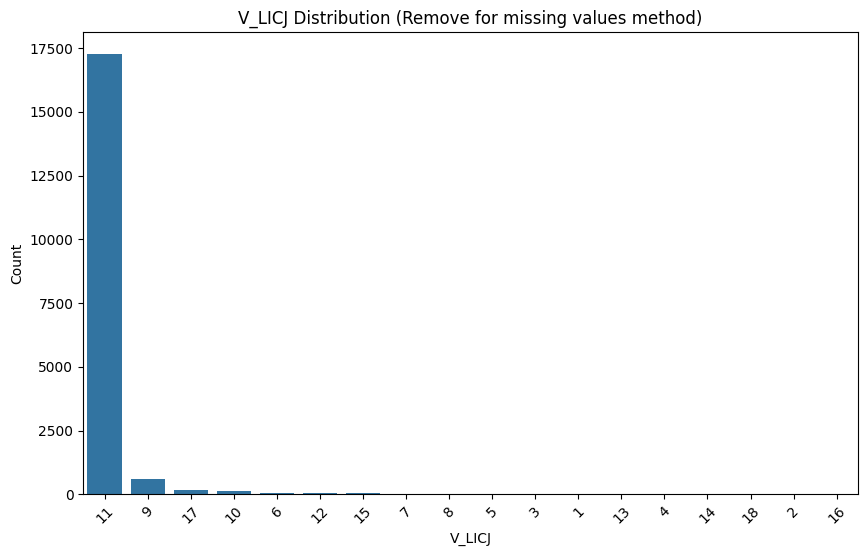

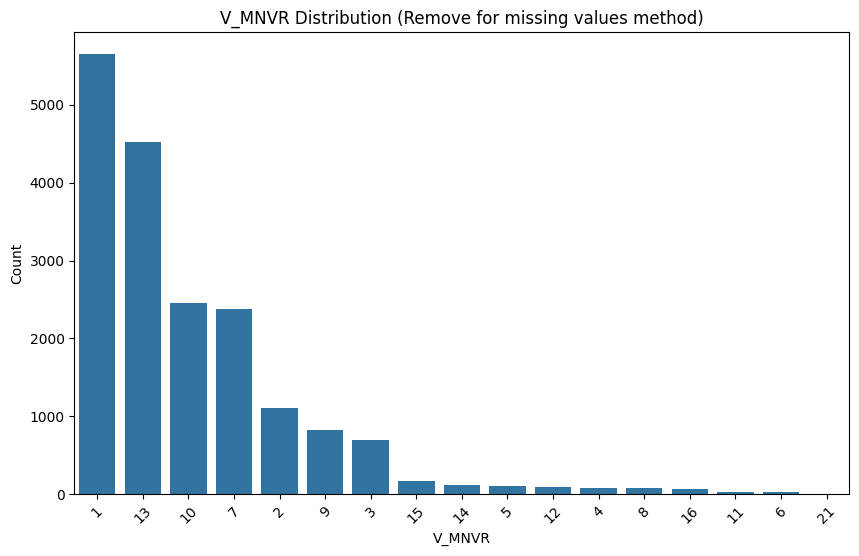

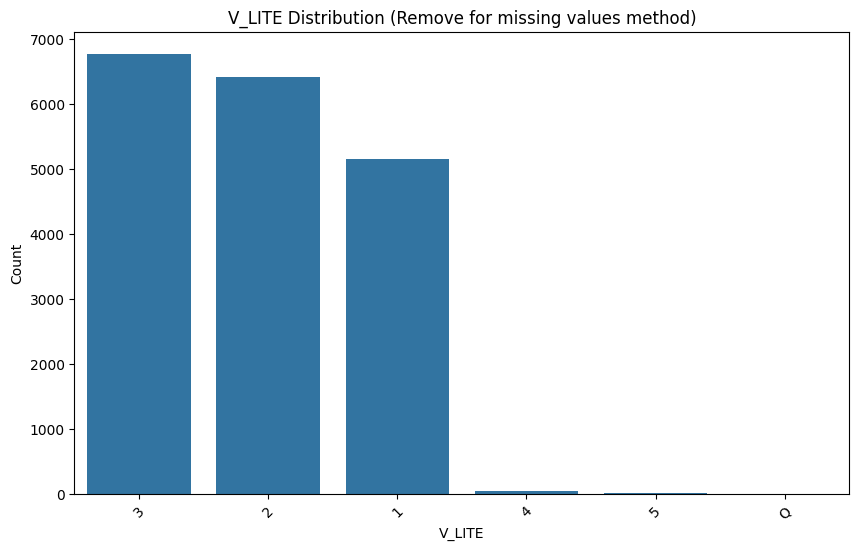

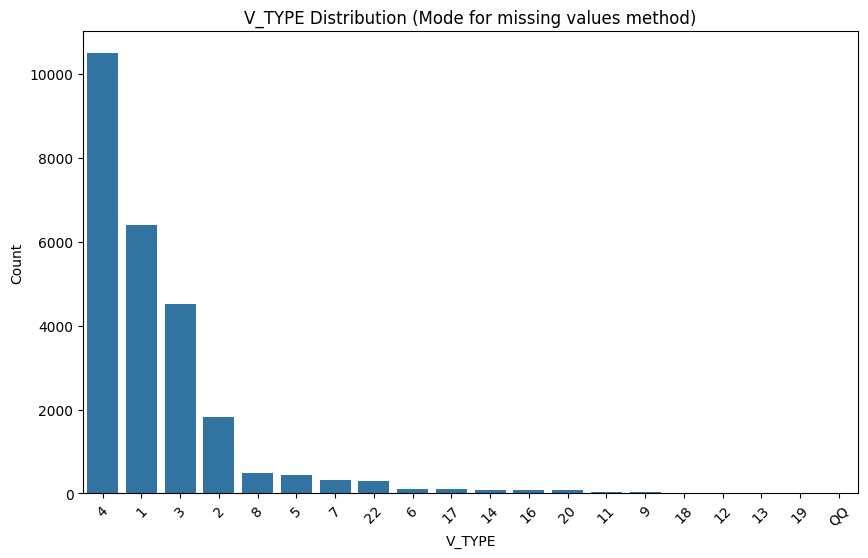

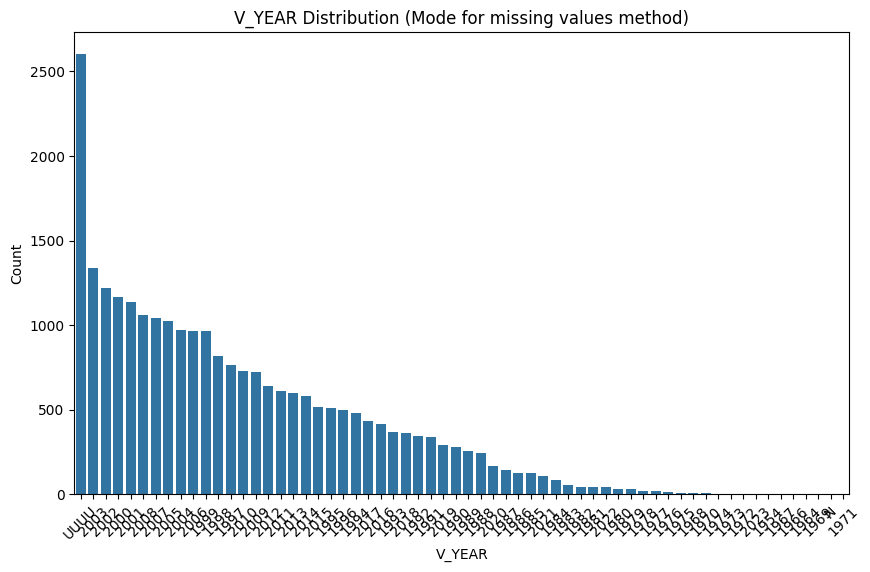

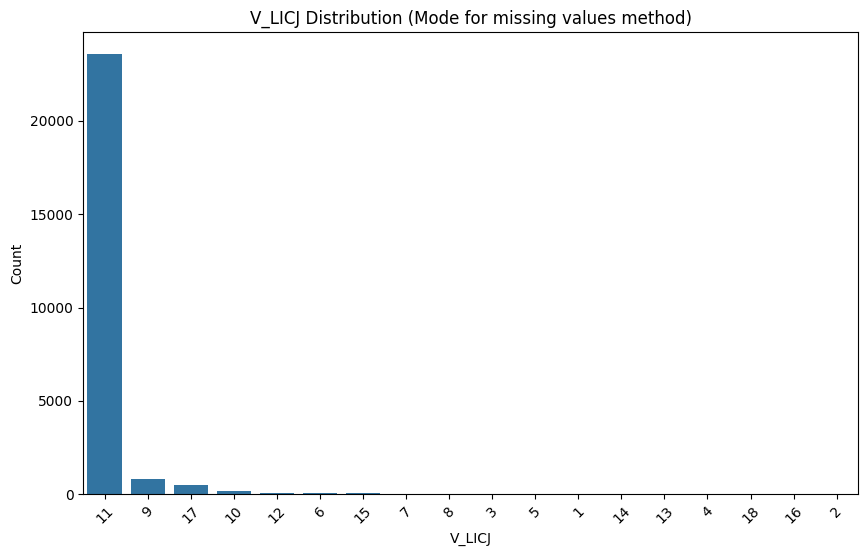

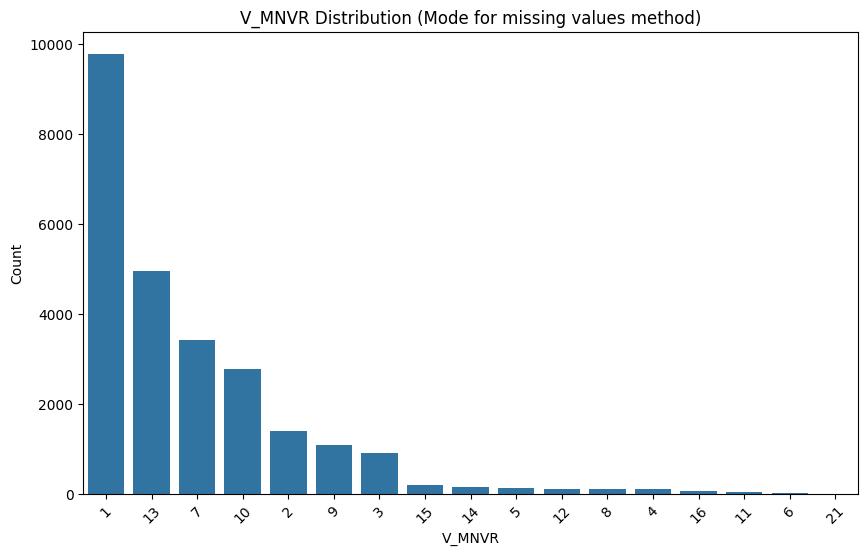

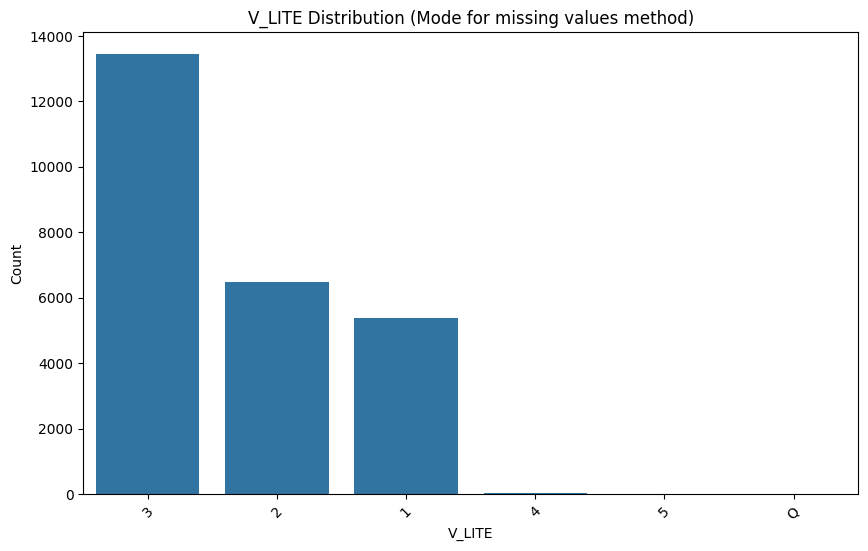

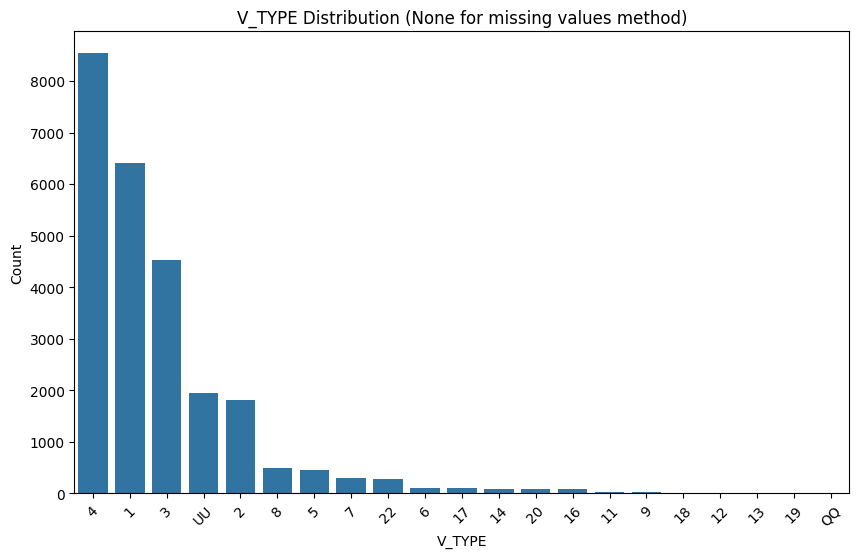

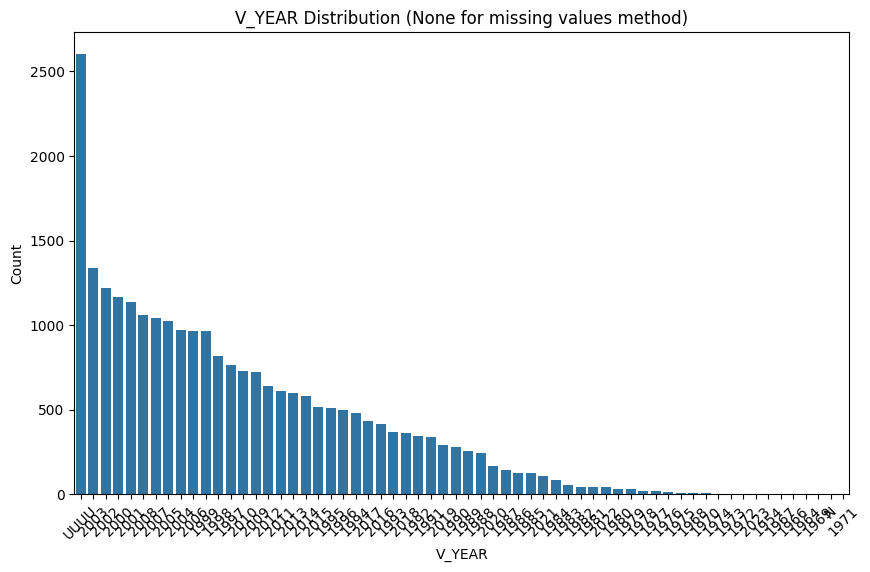

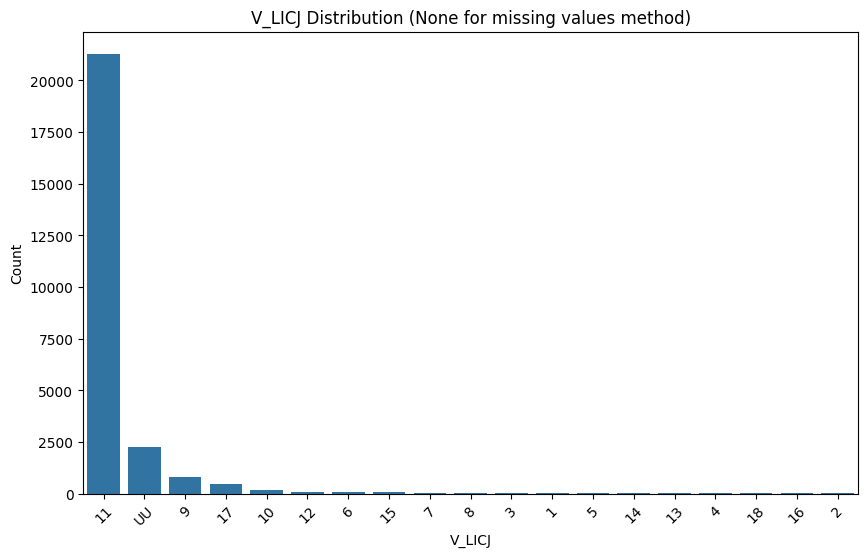

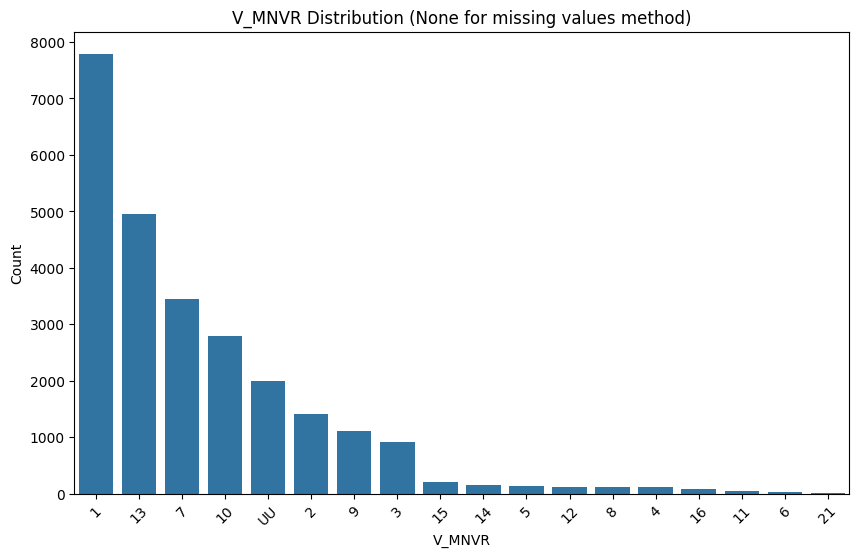

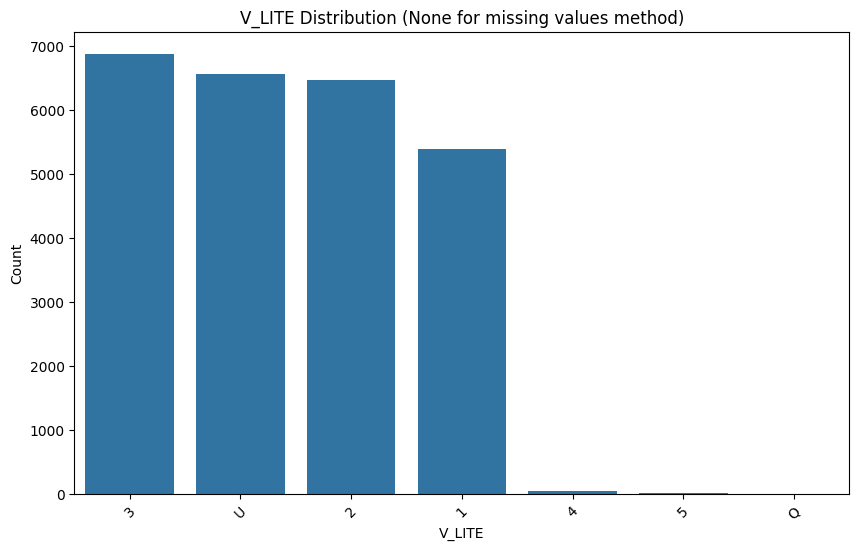

In [10]:
def plotHistograms(cleanedDfs, columns):
  for method, df in cleanedDfs:
    for column in columns:
      plt.figure(figsize=(10, 6))
      sns.countplot(data=df, x=column, order=df[column].value_counts().index)
      plt.title(f'{column} Distribution ({method} for missing values method)')
      plt.xlabel(column)
      plt.ylabel('Count')
      plt.xticks(rotation=45)
      plt.show()

plotHistograms(cleanedDfs, ['V_TYPE', 'V_YEAR', 'V_LICJ', 'V_MNVR', 'V_LITE'])

Remove


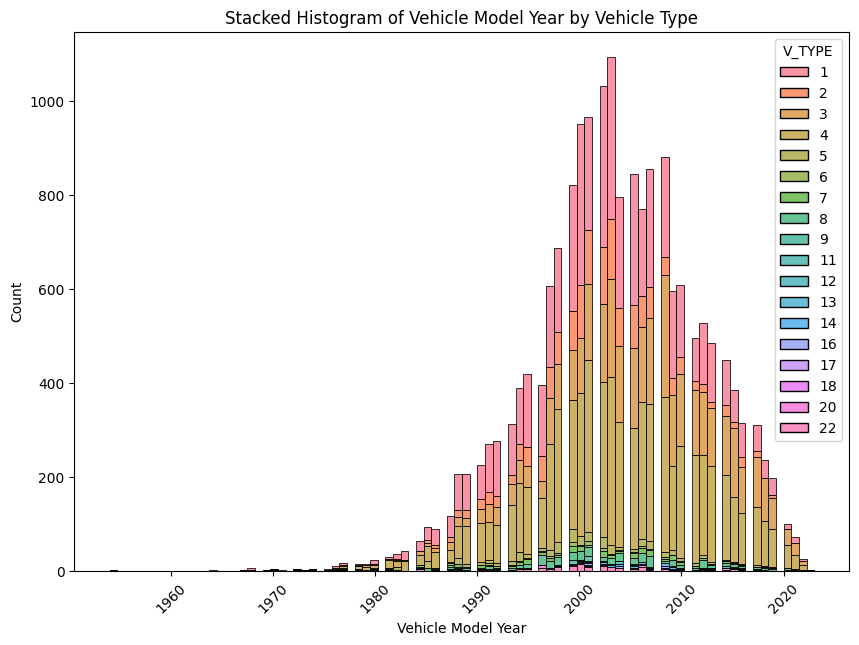

In [11]:
def drawStackdHisto(df, xCol='V_YEAR', hueCol='V_TYPE', _xlabel='Vehicle Model Year', _ylabel='Count', _title='Stacked Histogram of Vehicle Model Year by Vehicle Type'):
  # Plot the stacked histogram
  plt.figure(figsize=(10, 7))
  sns.histplot(data=df, x=xCol, hue=hueCol, stat='count',
               multiple='stack', palette=sns.color_palette("husl", len(df[hueCol].unique())), legend='auto')

  # Add labels and title
  plt.xlabel(_xlabel)
  plt.ylabel(_ylabel)
  plt.title(_title)
  plt.xticks(rotation=45)
  plt.show()

print(cleanedDfs[0][0])
drawStackdHisto(cleanedDfs[0][1])

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '14', '15', '16', '17', '18', '19', '20', '22', 'QQ', 'UU'])
Index(['V_TYPE', 'V_LITE', 'V_MNVR', 'V_YEAR', 'V_LICJ', 'V_REP',
       'V_TYPE_bins'],
      dtype='object')


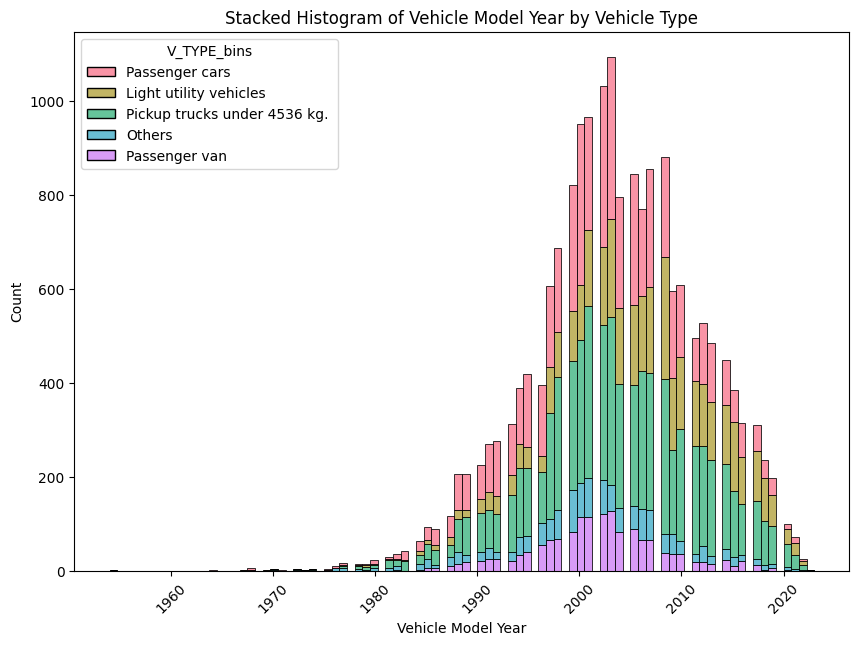

In [12]:
def binLowFreq(df, column, threshold=0.05):
  # Calculate the frequency of each category
  freq = df[column].value_counts(normalize=True) # normalize will do the math for us.

  lowFreqCat = freq[freq < threshold].index

  # Create a new column including binned values
  newColName = f"{column}_bins"
  df[newColName] = df[column].apply(lambda x: 'Others' if x in lowFreqCat else x)

  return df

def customRename(text, renameDict):
  text = str(text) if text is not None else None
  if renameDict is None or text is None:
    return text
  maxStrLength = max([len(key) for key in renameDict.keys()])
  # Convert text to padded amount
  padString = text.zfill(maxStrLength)
  if padString in renameDict:
    sol = renameDict[padString].split('-')[0]
    return sol.split('–')[0] # i guess they want me to suffer thats cool lol.
  else:
    return text


def renameColumnUsingDict(df, columnName, renameDict=None):
  print(vehicle_codes.keys())
  df[columnName] = df[columnName].apply(customRename, args=(renameDict,))
  return df

binnedDf = binLowFreq(cleanedDfs[0][1], 'V_TYPE')
binnedDf = renameColumnUsingDict(binnedDf, 'V_TYPE_bins', vehicle_codes)
print(binnedDf.columns)
drawStackdHisto(df=binnedDf, xCol='V_YEAR', hueCol='V_TYPE_bins')

Index(['V_TYPE', 'V_LITE', 'V_MNVR', 'V_YEAR', 'V_LICJ', 'V_REP',
       'V_TYPE_bins', 'V_MNVR_bins'],
      dtype='object')
V_MNVR_bins
1         5648
13        4526
10        2450
7         2372
Others    2289
2         1108
Name: count, dtype: int64
dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '14', '15', '16', '17', '18', '19', '20', '22', 'QQ', 'UU'])
V_MNVR_bins
Going straight ahead             5648
Stopped/parked legally           4526
Slowing or stopped in traffic    2450
Reversing                        2372
Others                           2289
Turning left                     1108
Name: count, dtype: int64


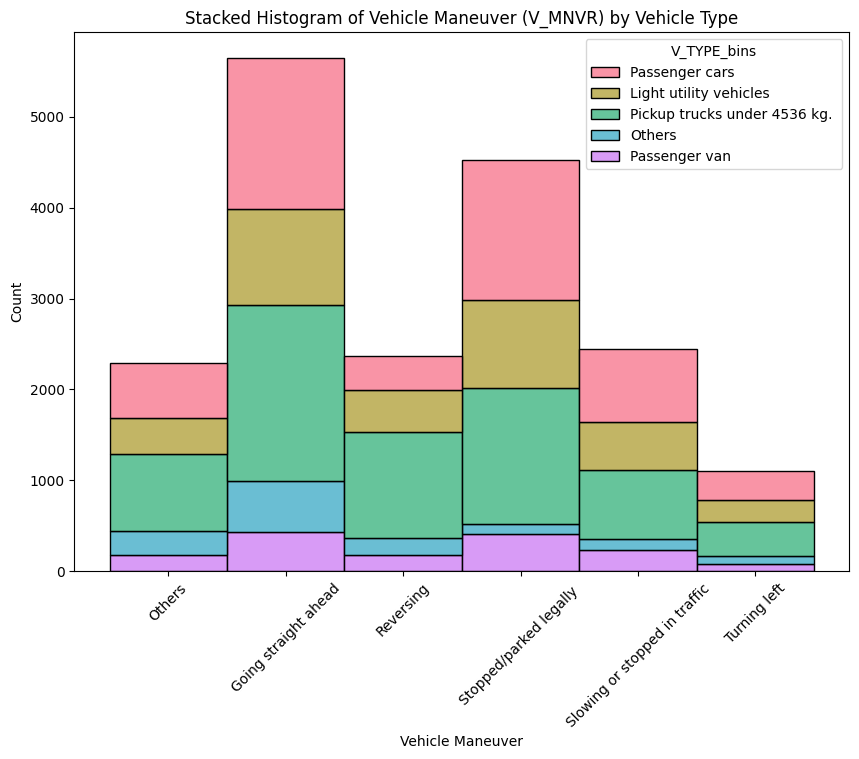

In [13]:
binnedDf = binLowFreq(binnedDf, 'V_MNVR')
print(binnedDf.columns)
print(binnedDf['V_MNVR_bins'].value_counts())
binnedDf = renameColumnUsingDict(binnedDf, 'V_MNVR_bins', vehicle_manoeuvres)
print(binnedDf['V_MNVR_bins'].value_counts())
drawStackdHisto(df=binnedDf, xCol='V_MNVR_bins', hueCol='V_TYPE_bins', _xlabel='Vehicle Maneuver',
                _title='Stacked Histogram of Vehicle Maneuver (V_MNVR) by Vehicle Type')

binnedDf.to_excel('binnedDf.xlsx')

Index(['V_TYPE', 'V_MNVR', 'V_YEAR'], dtype='object')


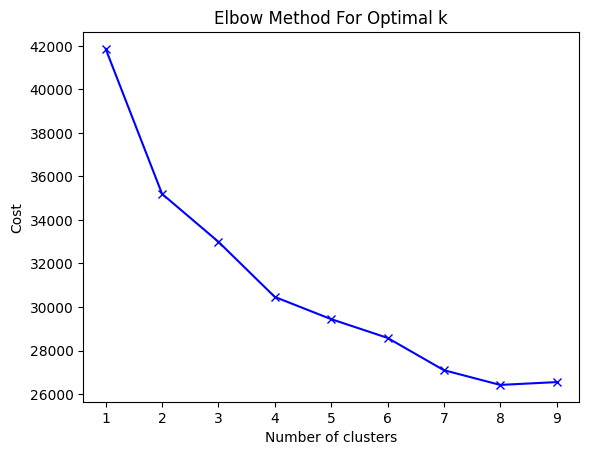

In [14]:
!pip install kmodes
from kmodes.kmodes import KModes

#cleanedDfs[0][1

testDf = cleanedDfs[0][1].copy()[['V_TYPE', 'V_MNVR', 'V_YEAR']]
print(testDf.columns)
for col in testDf.columns:
  testDf[col] = testDf[col].apply(str)



cost = []
K = range(1, 10)
for num_clusters in K:
    kmode = KModes(n_clusters=num_clusters, init='random', n_init=5, verbose=0)
    kmode.fit_predict(testDf)
    cost.append(kmode.cost_)

plt.plot(K, cost, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
kmodes = KModes(n_clusters=3, init='random', n_init=5, verbose=0)
clusters = kmodes.fit_predict(testDf)


In [16]:
clusterDf = testDf.copy()
clusterDf['Cluster'] = clusters
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder( sparse_output=False)
dfEncoded = encoder.fit_transform(testDf)

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=1000)
tsneRes = tsne.fit_transform(dfEncoded)
dfEncodedTSNE = dfEncoded.copy()
tsneDF = pd.DataFrame(tsneRes, columns=['t-SNE 1', 't-SNE 2'])
tsneDF['Cluster'] = clusterDf['Cluster']

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

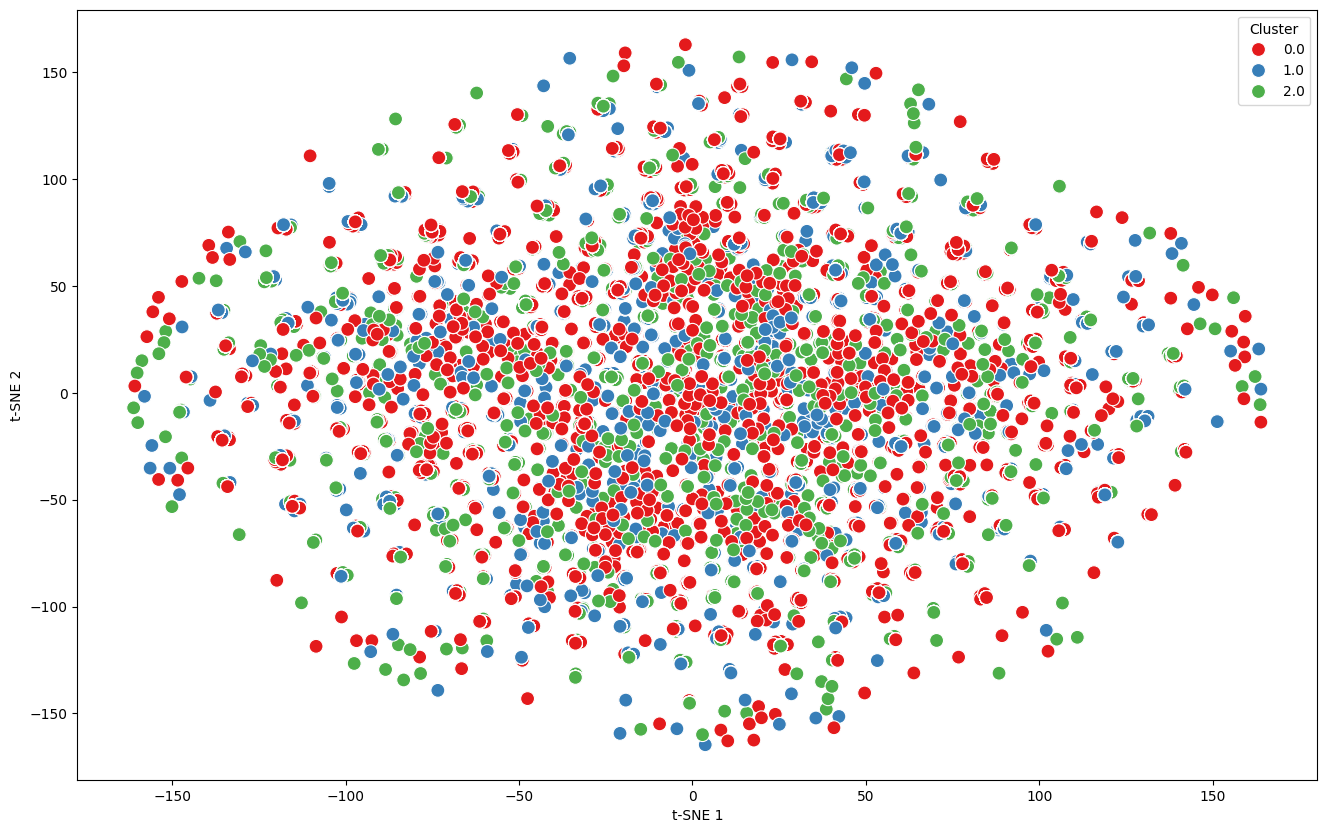

In [18]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    palette='Set1',
    hue='Cluster',
    s=100,
    data=tsneDF,

)

In [19]:
# pca = PCA(n_components=2)
# pcaDF = pca.fit_transform(dfEncoded)
# testDf['PCA1'] = pcaDF[:, 0]
# testDf['PCA2'] = pcaDF[:, 1]

In [20]:
# plt.figure(figsize=(10, 6))
# plt.scatter(testDf['PCA1'], testDf['PCA2'], c=testDf['Cluster'], cmap='viridis')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.title('PCA Clustering')
# plt.show()
